In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import spacy
from transformers import pipeline
import torch
from sklearn.datasets import load_files

# ---------------------- DOWNLOAD & EXTRACT BBC DATASET ----------------------
url = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
dataset_path = "bbc"
zip_path = "bbc.zip"

if not os.path.exists(dataset_path):
    print("Downloading BBC dataset...")
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

# ---------------------- NLTK SETUP ----------------------
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# ---------------------- CONFIG ----------------------
subcategory_lists = {
    'entertainment': ['music', 'cinema', 'theatre', 'television', 'celebrity_news', 'film_awards', 'book_reviews', 'TV_series', 'concerts', 'festival'],
    'business': ['stock_market', 'company_news', 'mergers_acquisitions', 'economic_policy', 'oil_energy', 'employment', 'housing_market', 'global_trade', 'technology_business', 'financial_markets'],
    'sport': ['football', 'cricket', 'rugby', 'tennis', 'olympics', 'athletics', 'motorsport', 'golf', 'boxing', 'cycling'],
    'politics': ['elections', 'government_policy', 'party_politics', 'international_relations', 'parliament_news', 'health_policy', 'education_policy', 'defense_policy', 'immigration', 'environment_policy'],
    'tech': ['mobile_tech', 'software', 'internet', 'hardware', 'gaming', 'cybersecurity', 'AI_ML', 'social_media', 'telecom', 'gadgets']
}

# ---------------------- LOAD BBC DATASET ----------------------
print("Loading BBC dataset...")
dataset = load_files("bbc", encoding="latin1", decode_error="replace")
df = pd.DataFrame({'text': dataset.data, 'category': dataset.target})
df['category'] = df['category'].apply(lambda i: dataset.target_names[i])

print(f"Original shape: {df.shape}")
df = df.drop_duplicates(subset='text')
print(f"After removing duplicates: {df.shape}")

# ---------------------- TEXT CLEANING ----------------------
print("Cleaning text...")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    tokens = word_tokenize(text.lower())
    filtered = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered)

df['clean_text'] = df['text'].apply(clean_text)

# ---------------------- SUBCATEGORY CLASSIFICATION USING DISTILBERT ----------------------
print("Loading DistilBERT classifier...")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def classify_with_distilbert(text, category):
    subcategories = subcategory_lists.get(category, [])
    if not subcategories:
        return f"{category}_topic_other"
    try:
        result = classifier(text[:1000], candidate_labels=subcategories)
        top_score = result['scores'][0]
        if top_score < 0.5:
            return f"{category}_topic_other"
        return result['labels'][0]
    except Exception as e:
        print(f"[CLASSIFICATION ERROR] {e}")
        return "error"

print("Classifying articles...")
tqdm.pandas()
df['subcategory'] = df.progress_apply(lambda row: classify_with_distilbert(row['clean_text'], row['category']), axis=1)

# ---------------------- NAMED ENTITY RECOGNITION + ROLES ----------------------
print("Extracting media personalities using spaCy...")
nlp = spacy.load("en_core_web_sm")
role_keywords = {
    "politician": ["minister", "mp", "senator", "president", "prime minister", "government"],
    "musician": ["singer", "band", "musician", "album", "song"],
    "actor": ["actor", "actress", "film", "movie", "tv"],
    "tv_personality": ["tv", "host", "presenter", "show"]
}

def extract_named_entities_with_roles(text):
    doc = nlp(text)
    persons = set([ent.text for ent in doc.ents if ent.label_ == "PERSON"])
    roles = {}
    for person in persons:
        if person in roles:
            continue
        lower_text = text.lower()
        assigned_role = "unknown"
        for role, keywords in role_keywords.items():
            if any(keyword in lower_text for keyword in keywords):
                assigned_role = role
                break
        roles[person] = assigned_role
    return roles

df['entities_with_roles'] = df['text'].apply(extract_named_entities_with_roles)

# ---------------------- APRIL EVENT SUMMARY ----------------------
print("Extracting April event summaries...")
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

def summarize_april_event(text):
    try:
        summary = summarizer(text[:1024], max_length=60, min_length=10, do_sample=False)[0]['summary_text']
        return summary
    except Exception as e:
        print(f"[SUMMARY ERROR] {e}")
        return ""

def extract_april_summary(text):
    if "april" in text.lower():
        return summarize_april_event(text)
    else:
        return ""

df['april_summary'] = df['text'].apply(extract_april_summary)

# ---------------------- DIAGNOSTICS ----------------------
print("Total articles processed:", len(df))
print("Subcategories assigned:", df['subcategory'].notna().sum())
print("Named entities extracted:", df['entities_with_roles'].notna().sum())
print("April summaries extracted:", (df['april_summary'] != "").sum())

# ---------------------- SAVE RESULTS ----------------------
df[['text', 'category', 'subcategory', 'entities_with_roles', 'april_summary']].to_csv("classified_bbc_articles_distilbert.csv", index=False)
print("Done. Results saved to 'classified_bbc_articles_distilbert.csv'.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading BBC dataset...
Original shape: (2225, 2)
After removing duplicates: (2127, 2)
Cleaning text...
Loading DistilBERT classifier...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


Classifying articles...


100%|██████████| 2127/2127 [18:19<00:00,  1.94it/s]


Extracting media personalities using spaCy...
Extracting April event summaries...


Device set to use cuda:0


Total articles processed: 2127
Subcategories assigned: 2127
Named entities extracted: 2127
April summaries extracted: 100
Done. Results saved to 'classified_bbc_articles_distilbert.csv'.


In [ ]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

print("Calculating coherence scores for BERT-assigned subcategories...")

coherence_results = []

for category in df['category'].unique():
    subcats = df[df['category'] == category]['subcategory'].unique()

    for subcat in subcats:
        texts = df[(df['category'] == category) & (df['subcategory'] == subcat)]['clean_text'].tolist()
        processed_texts = [simple_preprocess(text, deacc=True) for text in texts if text.strip() != '']

        if len(processed_texts) < 5:
            print(f"⚠️ Skipping '{subcat}' (too few documents: {len(processed_texts)})")
            continue

        dictionary = Dictionary(processed_texts)
        corpus = [dictionary.doc2bow(text) for text in processed_texts]

        # Extract most common words in the subcategory as a pseudo-topic
        word_freq = dictionary.dfs  # document frequency of each word
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        topn = 10
        topics = [[dictionary[id] for id, freq in sorted_words[:topn]]]

        coherence_model = CoherenceModel(
            topics=topics,
            texts=processed_texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_score = coherence_model.get_coherence()
        print(f"✅ Coherence for [{category} → {subcat}]: {coherence_score:.4f}")
        coherence_results.append((category, subcat, coherence_score))


Calculating coherence scores for BERT-assigned subcategories...
✅ Coherence for [business → business_topic_other]: 0.3286
✅ Coherence for [business → employment]: 0.3868
⚠️ Skipping 'stock_market' (too few documents: 1)
✅ Coherence for [tech → gaming]: 0.3171
✅ Coherence for [tech → tech_topic_other]: 0.3199
✅ Coherence for [tech → software]: 0.3341
✅ Coherence for [tech → internet]: 0.4082
✅ Coherence for [tech → telecom]: 0.3381
✅ Coherence for [tech → cybersecurity]: 0.3182
✅ Coherence for [tech → gadgets]: 0.3474
✅ Coherence for [politics → politics_topic_other]: 0.3270
✅ Coherence for [politics → elections]: 0.4018
✅ Coherence for [politics → immigration]: 0.5326
⚠️ Skipping 'party_politics' (too few documents: 1)
⚠️ Skipping 'government_policy' (too few documents: 1)
✅ Coherence for [sport → athletics]: 0.4363
✅ Coherence for [sport → olympics]: 0.3751
✅ Coherence for [sport → tennis]: 0.5121
✅ Coherence for [sport → sport_topic_other]: 0.4451
✅ Coherence for [sport → football]: 

In [ ]:
# --- Aggregate and print average coherence per main category ---
from collections import defaultdict
import numpy as np

category_to_scores = defaultdict(list)

for cat, subcat, score in coherence_results:
    category_to_scores[cat].append(score)

print("\n📊 Average Coherence Scores by Main Category:")
for cat, scores in category_to_scores.items():
    avg_score = np.mean(scores)
    print(f"🔸 {cat}: {avg_score:.4f}")



📊 Average Coherence Scores by Main Category:
🔸 business: 0.3577
🔸 tech: 0.3404
🔸 politics: 0.4205
🔸 sport: 0.4304
🔸 entertainment: 0.3784


In [ ]:
counts = df[['category', 'subcategory']].value_counts().reset_index(name='count')

# Sort by 'category' and then 'subcategory'
counts_sorted = counts.sort_values(by=['category', 'subcategory'], ascending=[True, True]).reset_index(drop=True)

counts_sorted

,category,subcategory,count
0,business,business_topic_other,455
1,business,employment,47
2,business,stock_market,1
3,entertainment,cinema,28
4,entertainment,concerts,3
5,entertainment,entertainment_topic_other,160
6,entertainment,festival,9
7,entertainment,film_awards,1
8,entertainment,music,108
9,entertainment,television,55


/tmp/ipython-input-8-3180829845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


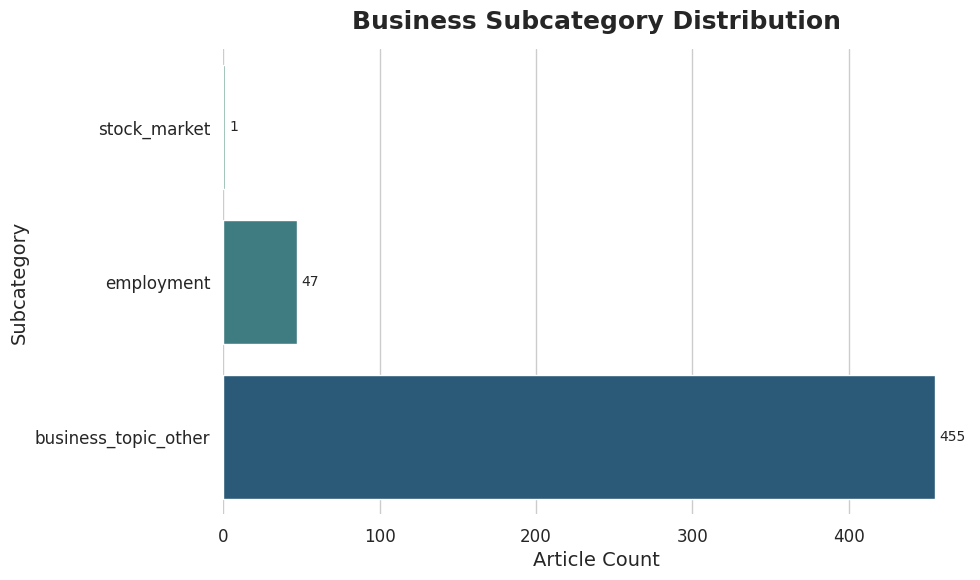

/tmp/ipython-input-8-3180829845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


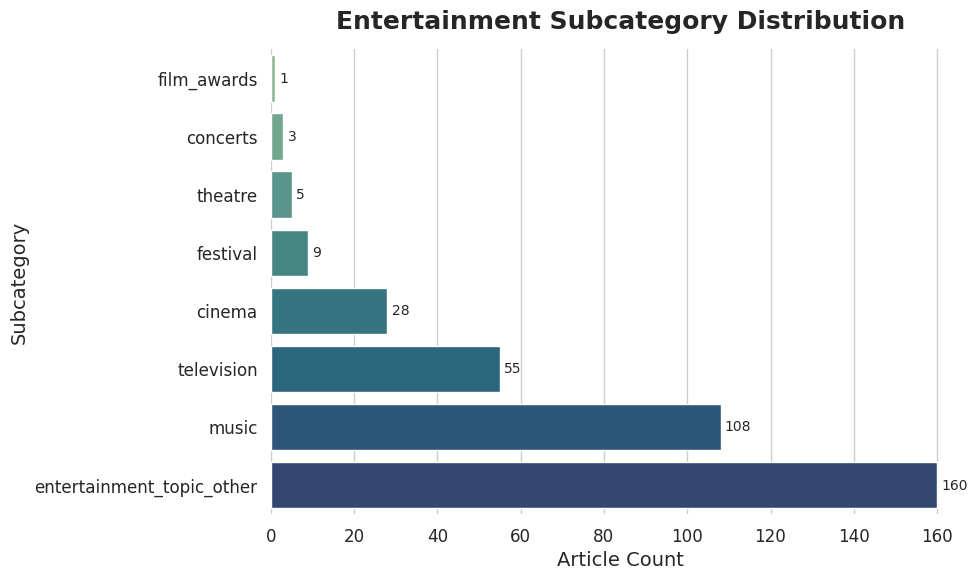

/tmp/ipython-input-8-3180829845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


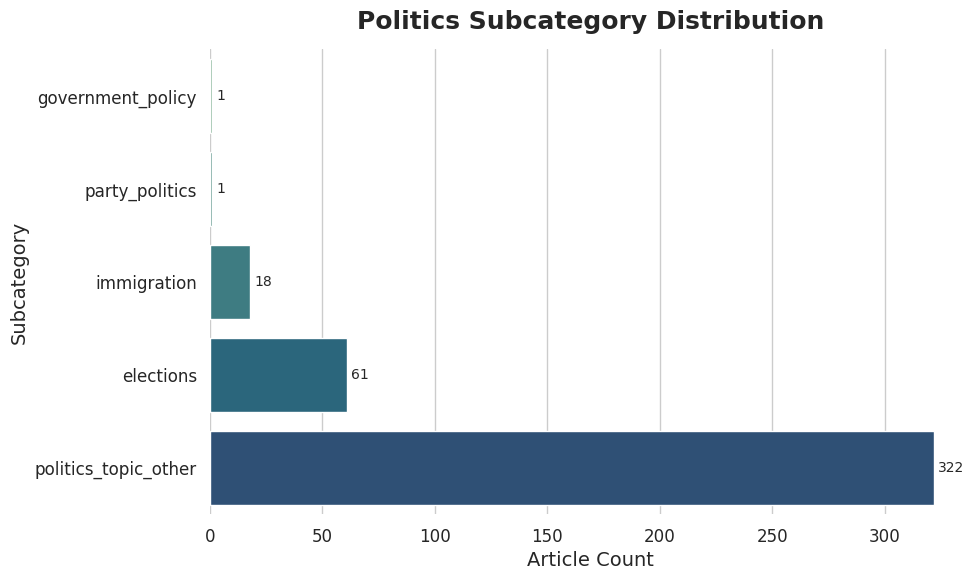

/tmp/ipython-input-8-3180829845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


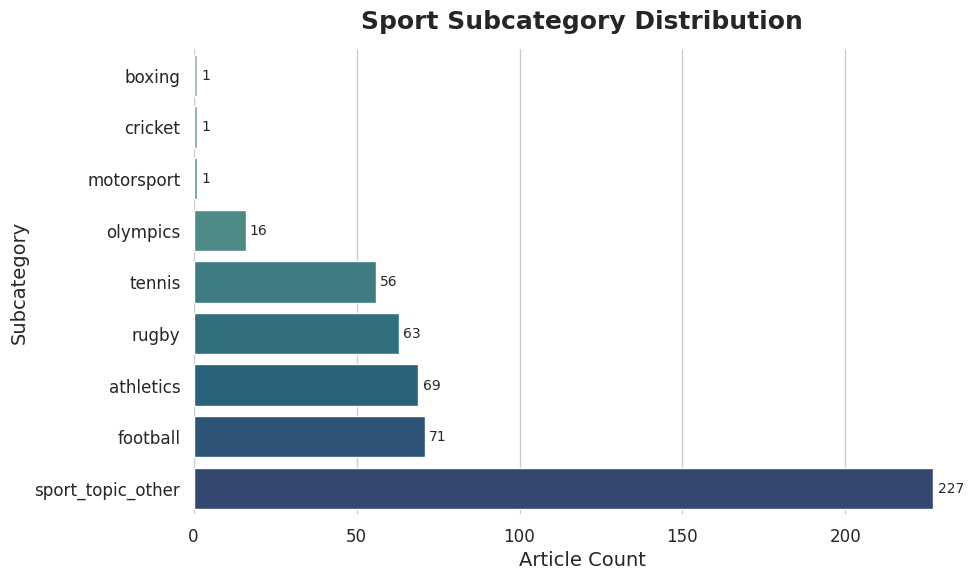

/tmp/ipython-input-8-3180829845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


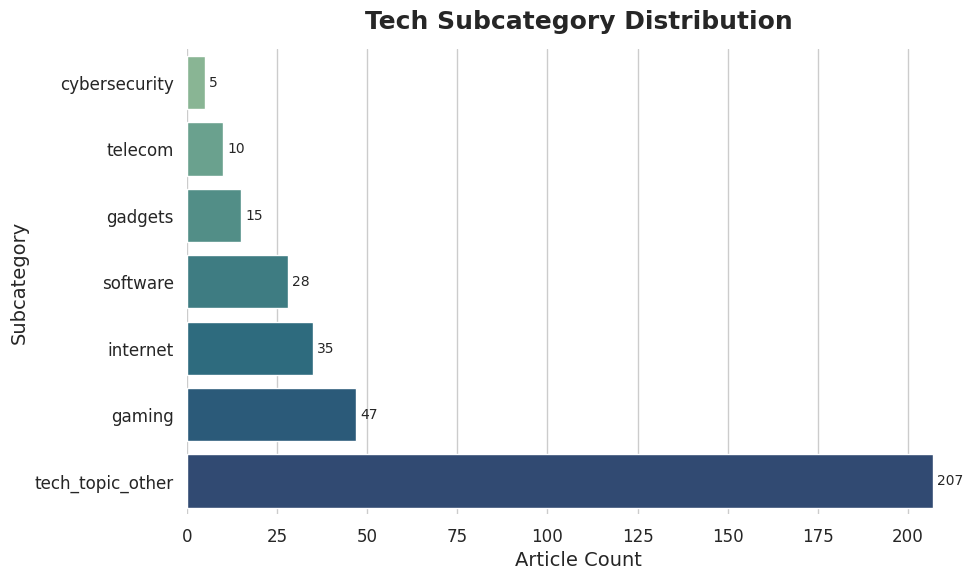

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Prepare Seaborn theme for a modern look
sns.set_theme(style="whitegrid", font_scale=1.1, palette="muted")

# Create individual plots per category
categories = counts_sorted['category'].unique()

for cat in categories:
    plt.figure(figsize=(10, 6))

    # Filter data for the category
    data_cat = counts_sorted[counts_sorted['category'] == cat].sort_values(by='count', ascending=True)

    # Barplot with color gradients
    colors = sns.color_palette("crest", len(data_cat))
    ax = sns.barplot(
        x='count',
        y='subcategory',
        data=data_cat,
        palette=colors
    )

    # Titles and labels
    ax.set_title(f"{cat.capitalize()} Subcategory Distribution", fontsize=18, weight='bold', pad=15)
    ax.set_xlabel('Article Count', fontsize=14)
    ax.set_ylabel('Subcategory', fontsize=14)

    # Add value labels for clarity
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

    # Remove spines for a cleaner aesthetic
    sns.despine(left=True, bottom=True)

    # Tight layout and display
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Use your counts_sorted DataFrame here

category_colors = {
    'business': '#636EFA',
    'entertainment': '#EF553B',
    'politics': '#00CC96',
    'sport': '#AB63FA',
    'tech': '#FFA15A'
}

fig = px.sunburst(
    counts_sorted,
    path=['category', 'subcategory'],
    values='count',
    color='category',
    color_discrete_map=category_colors,
    title='Interactive BBC Category and Subcategory Distribution (Distinct Rings)'
)

fig.update_layout(
    margin=dict(t=50, l=0, r=0, b=0),
    title_font_size=22,
    uniformtext=dict(minsize=10, mode='hide')
)

fig.show()
